In [1]:
!pip install tensorflow==2.0.0rc0 &> log
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 450kB 35.0MB/s 
     |████████████████████████████████| 3.9MB 58.3MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
!tar -xzf imagenette2.tgz

--2020-03-16 11:06:49--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.37.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.37.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G  35.2MB/s    in 43s     

2020-03-16 11:07:33 (34.8 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [0]:
import tensorflow as tf
import six

class HParams(object):
  def __init__(self, hparam_def=None, **kwargs):
    self._hparam_types = {}
    if hparam_def:
      self._init_from_proto(hparam_def)
      if kwargs:
        raise ValueError('hparam_def and initialization values are '
                         'mutually exclusive')
    else:
      for name, value in six.iteritems(kwargs):
        self.add_hparam(name, value)

  def add_hparam(self, name, value):
    if getattr(self, name, None) is not None:
      raise ValueError('Hyperparameter name is reserved: %s' % name)
    if isinstance(value, (list, tuple)):
      if not value:
        raise ValueError(
            'Multi-valued hyperparameters cannot be empty: %s' % name)
      self._hparam_types[name] = (type(value[0]), True)
    else:
      self._hparam_types[name] = (type(value), False)
    setattr(self, name, value)


In [0]:
import tensorflow as tf

class RevBlock(tf.keras.Model):
  """Single reversible block containing several `_Residual` blocks.
  Each `_Residual` block in turn contains two _ResidualInner blocks,
  corresponding to the `F`/`G` functions in the paper.
  """

  def __init__(self,
               n_res,
               filters,
               strides,
               input_shape,
               batch_norm_first=False,
               data_format="channels_first",
               bottleneck=False,
               fused=True,
               dtype=tf.float32):
    """Initialize RevBlock.
    Args:
      n_res: number of residual blocks
      filters: list/tuple of integers for output filter sizes of each residual
      strides: length 2 list/tuple of integers for height and width strides
      input_shape: length 3 list/tuple of integers
      batch_norm_first: whether to apply activation and batch norm before conv
      data_format: tensor data format, "NCHW"/"NHWC"
      bottleneck: use bottleneck residual if True
      fused: use fused batch normalization if True
      dtype: float16, float32, or float64
    """
    super(RevBlock, self).__init__()
    self.blocks = []
    for i in range(n_res):
      curr_batch_norm_first = batch_norm_first and i == 0
      curr_strides = strides if i == 0 else (1, 1)
      block = _Residual(
          filters,
          curr_strides,
          input_shape,
          batch_norm_first=curr_batch_norm_first,
          data_format=data_format,
          bottleneck=bottleneck,
          fused=fused,
          dtype=dtype)
      self.blocks.append(block)

      if data_format == "channels_first":
        input_shape = (filters, input_shape[1] // curr_strides[0],
                       input_shape[2] // curr_strides[1])
      else:
        input_shape = (input_shape[0] // curr_strides[0],
                       input_shape[1] // curr_strides[1], filters)

  def call(self, h, training=True):
    """Apply reversible block to inputs."""

    for block in self.blocks:
      h = block(h, training=training)
    return h

  def backward_grads_and_vars(self, y, dy, training=True):
    """Apply reversible block backward to outputs."""

    grads_all = []
    vars_all = []

    for i in reversed(range(len(self.blocks))):
      block = self.blocks[i]
      y, dy, grads, vars_ = block.backward_grads_and_vars(
          y, dy, training=training)
      grads_all += grads
      vars_all += vars_

    return y, dy, grads_all, vars_all


class _Residual(tf.keras.Model):
  """Single residual block contained in a _RevBlock. Each `_Residual` object has
  two _ResidualInner objects, corresponding to the `F` and `G` functions in the
  paper.
  Args:
    filters: output filter size
    strides: length 2 list/tuple of integers for height and width strides
    input_shape: length 3 list/tuple of integers
    batch_norm_first: whether to apply activation and batch norm before conv
    data_format: tensor data format, "NCHW"/"NHWC",
    bottleneck: use bottleneck residual if True
    fused: use fused batch normalization if True
    dtype: float16, float32, or float64
  """

  def __init__(self,
               filters,
               strides,
               input_shape,
               batch_norm_first=True,
               data_format="channels_first",
               bottleneck=False,
               fused=True,
               dtype=tf.float32):
    super(_Residual, self).__init__()

    self.filters = filters
    self.strides = strides
    self.axis = 1 if data_format == "channels_first" else 3
    if data_format == "channels_first":
      f_input_shape = (input_shape[0] // 2,) + input_shape[1:]
      g_input_shape = (filters // 2, input_shape[1] // strides[0],
                       input_shape[2] // strides[1])
    else:
      f_input_shape = input_shape[:2] + (input_shape[2] // 2,)
      g_input_shape = (input_shape[0] // strides[0],
                       input_shape[1] // strides[1], filters // 2)

    factory = _BottleneckResidualInner if bottleneck else _ResidualInner
    self.f = factory(
        filters=filters // 2,
        strides=strides,
        input_shape=f_input_shape,
        batch_norm_first=batch_norm_first,
        data_format=data_format,
        fused=fused,
        dtype=dtype)
    self.g = factory(
        filters=filters // 2,
        strides=(1, 1),
        input_shape=g_input_shape,
        batch_norm_first=batch_norm_first,
        data_format=data_format,
        fused=fused,
        dtype=dtype)

  def call(self, x, training=True, concat=True):
    """Apply residual block to inputs."""

    x1, x2 = tf.split(x, num_or_size_splits=2, axis=self.axis)
    f_x2 = self.f(x2, training=training)
    y1 = f_x2 + x1
    g_y1 = self.g(y1, training=training)
    y2 = g_y1 + x2
    if not concat:  # For correct backward grads
      return y1, y2

    return tf.concat([y1, y2], axis=self.axis)

  def backward_grads_and_vars(self, y, dy, training=True):
    """Manually compute backward gradients given input and output grads."""
    dy1, dy2 = tf.split(dy, num_or_size_splits=2, axis=self.axis)

    with tf.GradientTape(persistent=True) as tape:
      y = tf.identity(y)
      tape.watch(y)
      y1, y2 = tf.split(y, num_or_size_splits=2, axis=self.axis)
      z1 = y1
      gz1 = self.g(z1, training=training)
      x2 = y2 - gz1
      fx2 = self.f(x2, training=training)
      x1 = z1 - fx2

    grads_combined = tape.gradient(
        gz1, [z1] + self.g.trainable_variables, output_gradients=dy2)
    dz1 = dy1 + grads_combined[0]
    dg = grads_combined[1:]
    dx1 = dz1

    grads_combined = tape.gradient(
        fx2, [x2] + self.f.trainable_variables, output_gradients=dz1)
    dx2 = dy2 + grads_combined[0]
    df = grads_combined[1:]

    del tape

    grads = df + dg
    vars_ = self.f.trainable_variables + self.g.trainable_variables

    x = tf.concat([x1, x2], axis=self.axis)
    dx = tf.concat([dx1, dx2], axis=self.axis)

    return x, dx, grads, vars_


def _BottleneckResidualInner(filters,
                             strides,
                             input_shape,
                             batch_norm_first=True,
                             data_format="channels_first",
                             fused=True,
                             dtype=tf.float32):
  """Single bottleneck residual inner function contained in _Resdual.
  Corresponds to the `F`/`G` functions in the paper.
  Suitable for training on ImageNet dataset.
  Args:
    filters: output filter size
    strides: length 2 list/tuple of integers for height and width strides
    input_shape: length 3 list/tuple of integers
    batch_norm_first: whether to apply activation and batch norm before conv
    data_format: tensor data format, "NCHW"/"NHWC"
    fused: use fused batch normalization if True
    dtype: float16, float32, or float64
  Returns:
    A keras model
  """

  axis = 1 if data_format == "channels_first" else 3
  model = tf.keras.Sequential()
  if batch_norm_first:
    model.add(
        tf.keras.layers.BatchNormalization(
            axis=axis, input_shape=input_shape, fused=fused, dtype=dtype))
    model.add(tf.keras.layers.Activation("relu"))
  model.add(
      tf.keras.layers.Conv2D(
          filters=filters // 4,
          kernel_size=1,
          strides=strides,
          input_shape=input_shape,
          data_format=data_format,
          use_bias=False,
          padding="SAME",
          dtype=dtype))

  model.add(
      tf.keras.layers.BatchNormalization(axis=axis, fused=fused, dtype=dtype))
  model.add(tf.keras.layers.Activation("relu"))
  model.add(
      tf.keras.layers.Conv2D(
          filters=filters // 4,
          kernel_size=3,
          strides=(1, 1),
          data_format=data_format,
          use_bias=False,
          padding="SAME",
          dtype=dtype))

  model.add(
      tf.keras.layers.BatchNormalization(axis=axis, fused=fused, dtype=dtype))
  model.add(tf.keras.layers.Activation("relu"))
  model.add(
      tf.keras.layers.Conv2D(
          filters=filters,
          kernel_size=1,
          strides=(1, 1),
          data_format=data_format,
          use_bias=False,
          padding="SAME",
          dtype=dtype))

  return model


def _ResidualInner(filters,
                   strides,
                   input_shape,
                   batch_norm_first=True,
                   data_format="channels_first",
                   fused=True,
                   dtype=tf.float32):
  """Single residual inner function contained in _ResdualBlock.
  Corresponds to the `F`/`G` functions in the paper.
  Args:
    filters: output filter size
    strides: length 2 list/tuple of integers for height and width strides
    input_shape: length 3 list/tuple of integers
    batch_norm_first: whether to apply activation and batch norm before conv
    data_format: tensor data format, "NCHW"/"NHWC"
    fused: use fused batch normalization if True
    dtype: float16, float32, or float64
  Returns:
    A keras model
  """

  axis = 1 if data_format == "channels_first" else 3
  model = tf.keras.Sequential()
  if batch_norm_first:
    model.add(
        tf.keras.layers.BatchNormalization(
            axis=axis, input_shape=input_shape, fused=fused, dtype=dtype))
    model.add(tf.keras.layers.Activation("relu"))
  model.add(
      tf.keras.layers.Conv2D(
          filters=filters,
          kernel_size=3,
          strides=strides,
          input_shape=input_shape,
          data_format=data_format,
          use_bias=False,
          padding="SAME",
          dtype=dtype))

  model.add(
      tf.keras.layers.BatchNormalization(axis=axis, fused=fused, dtype=dtype))
  model.add(tf.keras.layers.Activation("relu"))
  model.add(
      tf.keras.layers.Conv2D(
          filters=filters,
          kernel_size=3,
          strides=(1, 1),
          data_format=data_format,
          use_bias=False,
          padding="SAME",
          dtype=dtype))

  return model

In [0]:
import functools
import operator

import matplotlib.pyplot as plt
import numpy as np
import six
import tensorflow as tf
#from blocks import RevBlock

class RevNet(tf.keras.Model):
  """RevNet that depends on all the blocks."""

  def __init__(self, config):
    """Initialize RevNet with building blocks.
    Args:
      config: HParams object; specifies hyperparameters
    """
    super(RevNet, self).__init__()
    self.axis = 1 if config.data_format == "channels_first" else 3
    self.config = config

    self._init_block = self._construct_init_block()
    self._block_list = self._construct_intermediate_blocks()
    self._final_block = self._construct_final_block()

  def _construct_init_block(self):
    init_block = tf.keras.Sequential(
        [
            tf.keras.layers.Conv2D(
                filters=self.config.init_filters,
                kernel_size=self.config.init_kernel,
                strides=(self.config.init_stride, self.config.init_stride),
                data_format=self.config.data_format,
                use_bias=False,
                padding="SAME",
                input_shape=self.config.input_shape,
                dtype=self.config.dtype),
        ],
        name="init")
    return init_block

  def _construct_final_block(self):
    f = self.config.filters[-1]  # Number of filters
    r = functools.reduce(operator.mul, self.config.strides, 1)  # Reduce ratio
    r *= self.config.init_stride

    if self.config.data_format == "channels_first":
      w, h = self.config.input_shape[1], self.config.input_shape[2]
      input_shape = (f, w // r, h // r)
    elif self.config.data_format == "channels_last":
      w, h = self.config.input_shape[0], self.config.input_shape[1]
      input_shape = (w // r, h // r, f)
    else:
      raise ValueError("Data format should be either `channels_first`"
                       " or `channels_last`")
    
    final_block = tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(),
            tf.keras.layers.Lambda(lambda x: tf.split(x, 
                                                      num_or_size_splits=[self.config.n_classes, 
                                                                          x.shape[-1] - self.config.n_classes], 
                                                      axis=1)[0])
        ],
        name="final")
    return final_block

  def _construct_intermediate_blocks(self):
    # Precompute input shape after initial block
    stride = self.config.init_stride
    if self.config.data_format == "channels_first":
      w, h = self.config.input_shape[1], self.config.input_shape[2]
      input_shape = (self.config.init_filters, w // stride, h // stride)
    else:
      w, h = self.config.input_shape[0], self.config.input_shape[1]
      input_shape = (w // stride, h // stride, self.config.init_filters)

    # Aggregate intermediate blocks

    block_list = []
    for i in range(self.config.n_rev_blocks):
      # RevBlock configurations
      n_res = self.config.n_res[i]
      filters = self.config.filters[i]
      if filters % 2 != 0:
        raise ValueError("Number of output filters must be even to ensure"
                         "correct partitioning of channels")
      stride = self.config.strides[i]
      strides = (self.config.strides[i], self.config.strides[i])

      # Add block
      rev_block = RevBlock(
          n_res,
          filters,
          strides,
          input_shape,
          batch_norm_first=(i != 0),  # Only skip on first block
          data_format=self.config.data_format,
          bottleneck=self.config.bottleneck,
          fused=self.config.fused,
          dtype=self.config.dtype)
      block_list.append(rev_block)

      # Precompute input shape for the next block
      if self.config.data_format == "channels_first":
        w, h = input_shape[1], input_shape[2]
        input_shape = (filters, w // stride, h // stride)
      else:
        w, h = input_shape[0], input_shape[1]
        input_shape = (w // stride, h // stride, filters)

    return block_list

  def call(self, inputs, training=True):
    """Forward pass."""

    if training:
      saved_hidden = [inputs]

    h = self._init_block(inputs, training=training)

    for block in self._block_list:
      h = block(h, training=training)
      
    if training:
      saved_hidden.append(h)

    logits = self._final_block(h, training=training)

    return (logits, saved_hidden) if training else (logits, None)

  def compute_loss(self, logits, labels):
    """Compute cross entropy loss."""

    if self.config.dtype == tf.float32 or self.config.dtype == tf.float16:
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
      cross_ent = loss_fn(y_true=labels, y_pred=logits)
    else:
      # `sparse_softmax_cross_entropy_with_logits` does not have a GPU kernel
      # for float64, int32 pairs
      labels = tf.one_hot(
          labels, depth=self.config.n_classes, axis=1, dtype=self.config.dtype)
      cross_ent = tf.nn.softmax_cross_entropy_with_logits(
          logits=logits, labels=labels)

    return tf.reduce_mean(cross_ent)

  def compute_gradients(self, inputs, labels, training=True, l2_reg=True):
    """Manually computes gradients.
    When eager execution is enabled, this method also SILENTLY updates the
    running averages of batch normalization when `training` is set to True.
    Args:
      inputs: Image tensor, either NHWC or NCHW, conforming to `data_format`
      labels: One-hot labels for classification
      training: Use the mini-batch stats in batch norm if set to True
      l2_reg: Apply l2 regularization
    Returns:
      list of tuples each being (grad, var) for optimizer to use
    """

    # Run forward pass to record hidden states; avoid updating running averages
    vars_and_vals = self.get_moving_stats()
    _, saved_hidden = self.call(inputs, training=training)
    self.restore_moving_stats(vars_and_vals)

    grads_all = []
    vars_all = []

    # Manually backprop through last block
    x = saved_hidden[-1]
    with tf.GradientTape() as tape:
      x = tf.identity(x)
      tape.watch(x)
      # Running stats updated below
      logits = self._final_block(x, training=training)
      loss = self.compute_loss(logits, labels)

    grads_combined = tape.gradient(loss,
                                   [x] + self._final_block.trainable_variables)
    dy, grads_ = grads_combined[0], grads_combined[1:]
    grads_all += grads_
    vars_all += self._final_block.trainable_variables

    # Manually backprop through intermediate blocks
    y = saved_hidden.pop()
    for block in reversed(self._block_list):
      y, dy, grads, vars_ = block.backward_grads_and_vars(
          y, dy, training=training)
      grads_all += grads
      vars_all += vars_

    # Manually backprop through first block
    x = saved_hidden.pop()
    assert not saved_hidden  # Cleared after backprop

    with tf.GradientTape() as tape:
      x = tf.identity(x)
      # Running stats updated below
      y = self._init_block(x, training=training)

    grads_all += tape.gradient(
        y, self._init_block.trainable_variables, output_gradients=dy)
    vars_all += self._init_block.trainable_variables

    # Apply weight decay
    if l2_reg:
      grads_all = self._apply_weight_decay(grads_all, vars_all)

    return grads_all, vars_all, loss

  def _apply_weight_decay(self, grads, vars_):
    """Update gradients to reflect weight decay."""
    # Don't decay bias
    return [
        g + self.config.weight_decay * v if v.name.endswith("kernel:0") else g
        for g, v in zip(grads, vars_)
    ]
  
  def get_moving_stats(self):
    """Get moving averages of batch normalization.
    This is needed to avoid updating the running average twice in one iteration.
    Returns:
      A dictionary mapping variables for batch normalization moving averages
      to their current values.
    """
    vars_and_vals = []

    def _is_moving_var(v):
      n = v.name
      return n.endswith("moving_mean:0") or n.endswith("moving_variance:0")

    for v in filter(_is_moving_var, self.variables):
      vars_and_vals.append((v, v.read_value()))

    return vars_and_vals

  def restore_moving_stats(self, vars_and_vals):
    """Restore moving averages of batch normalization.
    This is needed to avoid updating the running average twice in one iteration.
    Args:
      vars_and_vals: The dictionary mapping variables to their previous values.
    """
    for var_, val in vars_and_vals:
      var_.assign(val)

  def get_x(self, y):
    y = tf.reshape(y, (1, 224, 224, 32))
    for block in reversed(self._block_list):
      for i in reversed(range(len(block.blocks))):
          res_block = block.blocks[i]
          
          y1, y2 = tf.split(y, num_or_size_splits=2, axis=-1)
          z1 = y1
          gz1 = res_block.g(z1, training=False)
          x2 = y2 - gz1
          fx2 = res_block.f(x2, training=False)
          x1 = z1 - fx2
          x = tf.concat([x1, x2], axis=-1)
          y = x
    
    res_x = np.zeros(self.config.input_shape)
    for i in range(res_x.shape[0]):
      for j in range(res_x.shape[1]):
        res_x[i, j] = np.linalg.solve(self._init_block.trainable_variables[0][0, 0, :, :3].numpy().T, 
                                      y[0, i, j, :3].numpy())
    
    res_x = np.clip(res_x, 0, 1)
    plt.imshow(res_x)

    return res_x

  def get_nuisance(self, inputs):
    h = self._init_block(inputs, training=False)

    for block in self._block_list:
      h = block(h, training=False)

    logits = tf.keras.layers.Flatten()(h)

    _, nuisance = tf.split(logits, num_or_size_splits=[self.config.n_classes, logits.shape[-1] - self.config.n_classes], axis=1)

    return nuisance

In [0]:
import revnet
import ops
import blocks

In [0]:
def get_hparams_imagenette():
  config = ops.HParams()
  config.add_hparam("init_filters", 32)
  config.add_hparam("init_kernel", 1)
  config.add_hparam("init_stride", 1)
  config.add_hparam("n_classes", 10)
  config.add_hparam("n_rev_blocks", 3)
  config.add_hparam("n_res", [3, 3, 3])
  config.add_hparam("filters", [32, 32, 32])
  config.add_hparam("strides", [1, 1, 1])
  config.add_hparam("batch_size", 32)
  config.add_hparam("bottleneck", False)
  config.add_hparam("fused", True)
  config.add_hparam("init_max_pool", False)
  config.add_hparam("input_shape", (224, 224, 3))
  config.add_hparam("data_format", "channels_last")
  config.add_hparam("dtype", tf.float32)
  config.add_hparam("with_dense", False)

  config.add_hparam("epochs", 20)
  config.add_hparam("weight_decay", 2e-4)
  
  return config

In [9]:
config = get_hparams_imagenette()

imagegen = ImageDataGenerator(rescale=1/255.)

train = imagegen.flow_from_directory("imagenette2/train/", class_mode="sparse", shuffle=True, batch_size=config.batch_size, target_size=(224, 224))
val = imagegen.flow_from_directory("imagenette2/val/", class_mode="sparse", shuffle=False, batch_size=config.batch_size, target_size=(224, 224))

model = revnet.RevNet(config=config)

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


## Check invertibility

In [0]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)

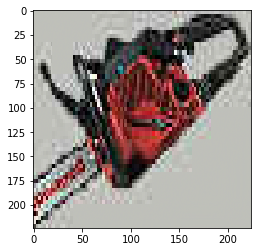

In [11]:
x, y = train.next()
x0 = tf.reshape(x[0], (1, *config.input_shape))

logits, _ = model(x0, training=False)
nuisance = model.get_nuisance(x0)

new_y = tf.concat([logits, nuisance], axis=1)
res_x = model.get_x(new_y)

In [12]:
np.max(abs(res_x - x0[0]))

9.191036e-05

## Learning

In [0]:
max_val_acc = None

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 2.2191312313079834
Training acc over epoch: 0.11109937727451324

Val loss over epoch: 2.2267284393310547
Val acc over epoch: 0.16713376343250275

Epoch: 2
Training loss over epoch: 2.1245017051696777
Training acc over epoch: 0.21649593114852905

Val loss over epoch: 2.1451826095581055
Val acc over epoch: 0.222675159573555

Epoch: 3
Training loss over epoch: 2.0997281074523926
Training acc over epoch: 0.24025768041610718

Val loss over epoch: 2.1865272521972656
Val acc over epoch: 0.18853503465652466

Epoch: 4
Training loss over epoch: 2.079348087310791
Training acc over epoch: 0.25166332721710205

Val loss over epoch: 2.1245274543762207
Val acc over epoch: 0.2321019172668457

Epoch: 5
Training loss over epoch: 2.0615642070770264
Training acc over epoch: 0.26496991515159607

Val loss over epoch: 2.1356005668640137
Val acc over epoch: 0.21503184735774994

Epoch: 6
Training loss over epoch: 2.04474139213562
Training acc over epoch: 0.2635970115661621

Va

In [0]:
max_val_acc = None

optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)

for epoch in range(config.epochs):
    train_mean_loss = tf.keras.metrics.Mean()
    val_mean_loss = tf.keras.metrics.Mean()

    train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

    for step in range(int(np.ceil(train.samples / train.batch_size))):
        x_batch_train, y_batch_train = train.next()

        grads, vars_, loss = model.compute_gradients(x_batch_train, y_batch_train, training=True)
        optimizer.apply_gradients(zip(grads, vars_))
        
        logits, _ = model(x_batch_train, training=False)
        train_acc_metric(y_batch_train, logits)
        train_mean_loss(loss)

    for step in range(int(np.ceil(val.samples / val.batch_size))):
        x_batch_val, y_batch_val = val.next()

        logits, _ = model(x_batch_val, training=False)
        loss = model.compute_loss(logits=logits, labels=y_batch_val)

        val_acc_metric(y_batch_val, logits)
        val_mean_loss(loss)

    print('Epoch: %s' % (epoch + 1,))
    print('Training loss over epoch: %s' % (float(train_mean_loss.result()),))
    print('Training acc over epoch: %s' % (float(train_acc_metric.result()),))
    print()
    print('Val loss over epoch: %s' % (float(val_mean_loss.result()),))
    print('Val acc over epoch: %s' % (float(val_acc_metric.result()),))
    print()

    if max_val_acc is None or float(val_acc_metric.result()) > max_val_acc:
        model.save_weights("drive/My Drive/Диплом/revnet_without_dense.hdf5")
        max_val_acc = float(val_acc_metric.result())


Epoch: 1
Training loss over epoch: 1.7196656465530396
Training acc over epoch: 0.42042455077171326

Val loss over epoch: 2.1429972648620605
Val acc over epoch: 0.25783440470695496

Epoch: 2
Training loss over epoch: 1.6929105520248413
Training acc over epoch: 0.43774423003196716

Val loss over epoch: 2.149707317352295
Val acc over epoch: 0.25707006454467773

Epoch: 3
Training loss over epoch: 1.6773629188537598
Training acc over epoch: 0.4434470236301422

Val loss over epoch: 2.1552250385284424
Val acc over epoch: 0.2647133767604828

Epoch: 4
Training loss over epoch: 1.6716859340667725
Training acc over epoch: 0.4471433162689209

Val loss over epoch: 2.169184684753418
Val acc over epoch: 0.2555414140224457

Epoch: 5
Training loss over epoch: 1.6621949672698975
Training acc over epoch: 0.4469321072101593

Val loss over epoch: 2.162449359893799
Val acc over epoch: 0.2588534951210022

Epoch: 6
Training loss over epoch: 1.6530643701553345
Training acc over epoch: 0.45316293835639954

Val 